Links
* [kaldi paper](https://www.danielpovey.com/files/2014_icassp_pitch.pdf)
* [wantee](http://wantee.github.io/2015/03/14/feature-extraction-for-asr-pitch/)
* [rapt](https://www.ee.columbia.edu/~dpwe/papers/Talkin95-rapt.pdf)
* [jiao, zhimi, chaocheng](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6375195)
* [online viterbi](http://www.dcs.fmph.uniba.sk/diplomovky/obhajene/getfile.php/main.pdf?id=143&fid=289&type=application%2Fpdf) and [here](https://pdfs.semanticscholar.org/fbd5/a448a6cd59e7af8a213edae98a3703459eb0.pdf)
* [lvhang](https://github.com/LvHang/pitch/tree/master/src)

In [205]:
import math
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import torchaudio

In [207]:
# Voice sound
# dataset = torchaudio.datasets.YESNO("~/yesno")
# waveform = dataset[0][0]
# sample_rate = 8 * 10**3

# Train sound
# filename = "_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"

# filename = "Audio_Sample_-_The_Quick_Brown_Fox_Jumps_Over_The_Lazy_Dog.wav"
# filename = "from_research_to_production.wav"
# filename = "research_to_prod_2.wav"
filename = "To-be-or-not-to-be-Kenneth-Branagh-HD-HAMLET-AudioTrimmer.com.wav"
waveform, sample_rate = torchaudio.load(filename)
# waveform = torchaudio.transforms.Resample(orig_freq=sample_rate,new_freq=16000)(waveform)
# sample_rate = 16000

# Convert to mono
waveform = waveform.mean(0).view(1,-1)

# plt.plot(waveform.t())

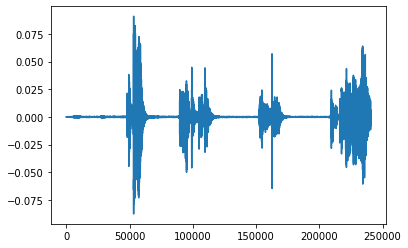

In [208]:
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate,new_freq=16000)(waveform)

plt.plot(waveform.t())

In [5]:
# w = torch.arange(100, dtype=torch.float64) + 1
# w = torch.randn(100)

In [383]:
lags = 400
frame_time = 10**-2
frame_size = int(math.ceil(sample_rate*frame_time))
EPSILON = 10**(-9)

w = waveform.view(-1)
waveform_length = w.size()[-1]
num_of_frames = math.ceil(waveform_length/frame_size)

p = lags + num_of_frames * frame_size - waveform_length
w = torch.nn.functional.pad(w, (0, p))

# get lags
output_lag = []
for lag in range(1,lags+1):
    s1 = w[:-lag].unfold(0, frame_size, frame_size)
    s2 = w[lag:].unfold(0, frame_size, frame_size)
    output_frames = (s1*s2).sum(-1)/(EPSILON + s1.norm(dim=-1))/(EPSILON + s2.norm(dim=-1))
    output_lag.append(output_frames.view(-1,1))

r2 = torch.cat(output_lag, 1)

print(r2.shape)
print(r2.abs().max())

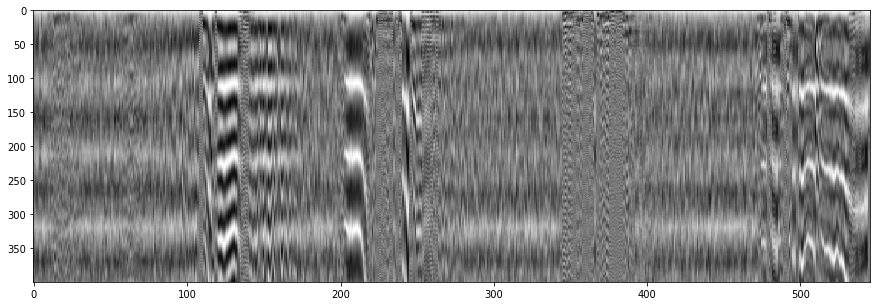

In [377]:
# correllograms

plt.figure(figsize=(15,5))
plt.imshow(r2.t(), cmap="gray", aspect="auto")

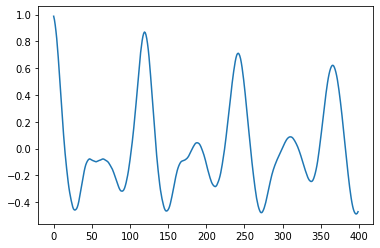

In [378]:
plt.plot(r2[500])  # Voice

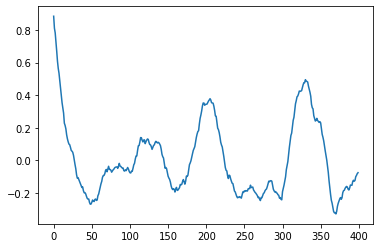

In [379]:
plt.plot(r2[50])  # Silence

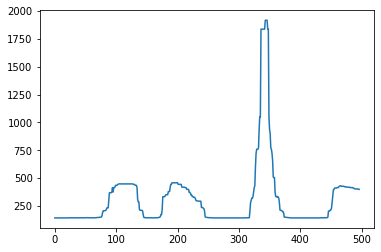

In [410]:
# https://en.wikipedia.org/wiki/Voice_frequency
# Usable voice frequencies for telephony: 30-3400 Hz
# Fundamental Frequency: 85-180 Hz or 165-255 Hz

smoothing_window = 50  # in units of frames

# Voice frequency is no shorter
lag_min = math.ceil(sample_rate/3400)  # Around 10 samples

# Find max
values, indices = torch.max(r2[:,lag_min:], -1)

# Median smoothing
roll = indices.unfold(0, smoothing_window, 1)
values, indices = torch.median(roll, -1)
freq = sample_rate/values

plt.plot(freq)
# plt.plot((float(sample_rate)/values.type(torch.DoubleTensor).log()))

# [WIP] Using tril

In [128]:
lags = 400
frame_time = 10**-2
frame_size = int(math.ceil(sample_rate*frame_time))

w = waveform.view(-1)
waveform_length = waveform.size()[-1]
num_of_frames = math.ceil(waveform_length/frame_size)

# get lags
r = torch.nn.functional.pad(w, (0,lags)).repeat(lags)[...,:-lags].view(lags,-1)
r -= torch.tril(r, diagonal=-1, out=None)
r = r[...,lags:]

# pad to whole frames
pr = (1+r.shape[-1]//(lags*frame_size))*lags*frame_size - r.shape[-1]
pw = (1+w.shape[-1]//(lags*frame_size))*lags*frame_size - w.shape[-1]
r = torch.nn.functional.pad(r, (0, pr)).view(frame_size, -1, lags)
w0 = torch.nn.functional.pad(w, (0, pw)).view(frame_size, -1)

# truncate to whole frames
# r = r[...,:i].view(frame_size, -1, lags)
# w0 = w[...,:i].view(frame_size, -1)

r /= torch.norm(r, dim=0)
r /= torch.norm(w0)
r[torch.isnan(r)] = 0  # padding to whole frames causes division by zeros

r *= w0.view(*w0.shape, 1).repeat(1, 1, r.shape[-1])
r = r.sum(0)

# frames x lags
r.shape

torch.Size([1200, 400])

In [105]:
r.shape

torch.Size([800, 400])

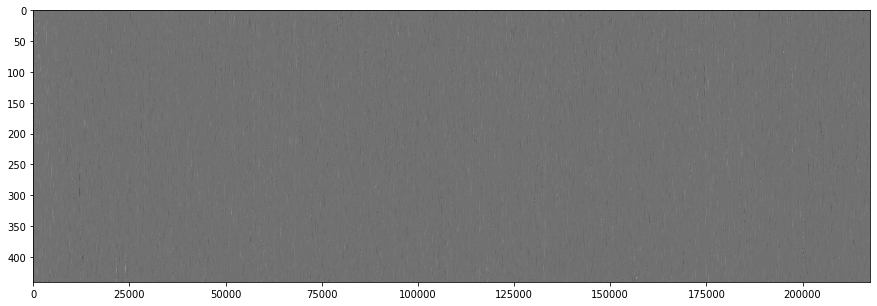

In [85]:
# correllograms

plt.figure(figsize=(15,5))
plt.imshow(r.t(), cmap="gray", aspect="auto")

In [9]:
560*frame_size

246960

In [10]:
r.shape

torch.Size([560, 40])

In [11]:
300000//frame_size

680

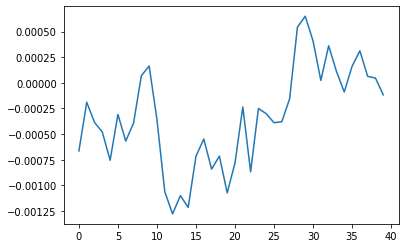

In [12]:
s = int(20*10**(-3))
plt.plot(r[s//frame_size,:])

In [18]:
r.argmax(dim=-1)

tensor([29, 38,  3, 34, 25, 36,  2, 22, 36, 35,  1, 37, 32, 12, 19,  2, 32, 10,
         9, 38,  0,  8, 25, 24,  6, 15,  0, 38,  0, 24, 27, 16, 18, 15,  7, 37,
         8, 12, 21, 26, 16, 12, 24, 38, 39, 34,  2, 19,  6, 39,  8, 34, 18, 15,
         1,  0, 12, 34, 18, 30,  6, 11, 38,  3, 11, 18,  8, 12, 17, 38,  0, 32,
         1,  9, 29, 36, 28, 29, 36, 24,  4,  8,  8, 17, 39, 11, 20, 32, 13, 10,
        24, 18, 33, 19, 29, 27, 11,  0, 34,  1,  1, 39,  2, 17, 33,  1, 16, 29,
        12, 33, 37, 16, 24, 36, 18, 21,  2, 20, 33,  7,  4, 28, 38,  3, 38, 39,
         7, 38, 32,  0, 36,  0, 10, 39, 20,  0,  7, 24,  0, 38, 22, 39,  5,  9,
        39, 33, 31, 39, 20, 14, 39, 19, 38,  0, 34, 31,  5,  9, 26,  2, 12, 35,
        13, 18, 29, 26, 27, 13, 11, 29, 36,  0,  3, 36, 32, 14, 30,  2, 36, 14,
        19, 21,  7, 38,  0,  7, 38,  0, 14, 39,  1,  3, 12, 37,  0,  0, 19, 17,
        30, 39, 11, 23,  6, 18, 39,  0, 28, 36,  1, 38,  5, 14, 13, 39,  7,  8,
        33, 36,  3, 20, 11, 38, 39,  0, 